In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## De-noising with PCA

For more reading, visit: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 784)
(10000, 784)


In [ ]:
mnist_noise = tf.keras.datasets.mnist
(x_train_noise, y_train_noise), (x_test_noise, y_test_noise) = mnist_noise.load_data()

x_train_noise = x_train_noise + np.random.randint(64, size=(60000, 28, 28))
x_test_noise = x_test_noise + np.random.randint(64, size=(10000, 28, 28))
x_train_noise = x_train_noise.astype('float32') / 255.0
x_test_noise = x_test_noise.astype('float32') / 255.0
x_train_noise = x_train_noise.reshape((len(x_train_noise), np.prod(x_train_noise.shape[1:])))
x_test_noise = x_test_noise.reshape((len(x_test_noise), np.prod(x_test_noise.shape[1:])))

print(x_train_noise.shape)
print(x_test_noise.shape)

(60000, 784)
(10000, 784)


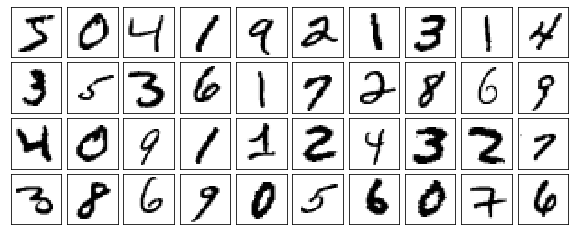

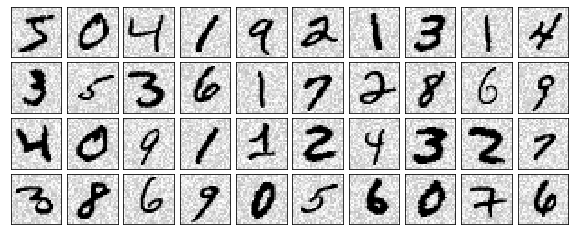

In [ ]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(28, 28),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 1))
plot_digits(x_train)
plot_digits(x_train_noise)

In [ ]:
pca2 = PCA(2)  # project from 64 to 2 dimensions
projected = pca2.fit_transform(x_train_noise.data)
print(x_train_noise.data.shape)
print(projected.shape)

(60000, 784)
(60000, 2)


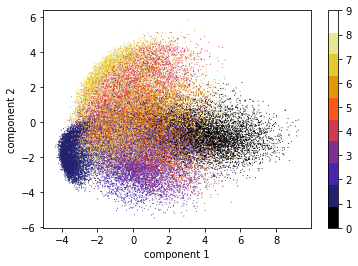

In [ ]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=y_train_noise, edgecolor='none', s=1,
            cmap=plt.cm.get_cmap('CMRmap', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [ ]:
pca = PCA(0.999999).fit(x_train_noise)
pca.n_components_

784

In [ ]:
pca = PCA(1).fit(x_train_noise)
pca.n_components_

1

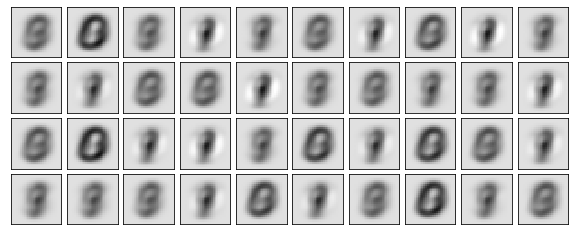

In [ ]:
components = pca.transform(x_train_noise)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

In [ ]:
pca = PCA(0.8).fit(x_train_noise)
pca.n_components_

62

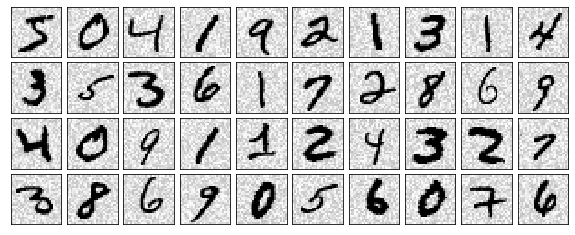

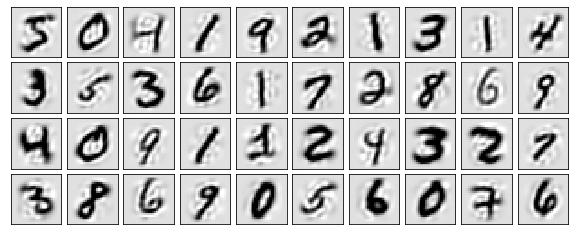

In [ ]:
components = pca.transform(x_train_noise)
filtered = pca.inverse_transform(components)
plot_digits(x_train_noise)
plot_digits(filtered)

## Autoencoders


Autoencoders are a specific type of feedforward neural networks where the input is the same as the output. They compress the input into a lower-dimensional code and then reconstruct the output from this representation. The code is a compact “summary” or “compression” of the input, also called the latent-space representation.


An autoencoder consists of 3 components: encoder, code and decoder. The encoder compresses the input and produces the code, the decoder then reconstructs the input only using this code.

To build an autoencoder we need 3 things: an encoding method, decoding method, and a loss function to compare the output with the target.

Autoencoders are mainly a dimentionality reduction/compression tool.

![picture](https://miro.medium.com/max/1200/1*C6Z6i1_2EJn13jVEsAOkRQ@2x.png)
The expected output is generally the same as the input(de-noising encoders are an example where this isn't the case).

The encoder part takes the raw data and "encodes" it into a space with lower dimensions. 

The decoder part then takes this lower dimensional encoding and tries to reconstruct the original data.


This sort of algorithm allows us to "compress" data and make data sharing more efficient. For video playback, each frame might be encoded and the encoded/compressed form of the data might be sent to the user, which would then be decoded on their end with the help of the decoder module.


the dimension of the code layer directly influences the "compression factor" and is treated as a hyperparameter.

We need to set the following hyperparameters before training an autoencoder.

- Code size: The number of nodes in the code layer.
- Number of layers: Similar as deciding the number of layers in a general FFNN.
- Number of nodes per layer: Also same as deciding on the layer depth in an FFNN.
- Loss function: we either use mean squared error (mse) or binary crossentropy. If the input values are in the range [0, 1] then we typically use crossentropy, otherwise we use the mean squared error.

### Coding an autoencoder

Now we will code an autoencoder for our beloved MNIST digit dataset.
I will put 2 hidden layers in the encoder and the decoder. Noisy data is provided as the input and clean data as the output. So, the autoencoder learns to remove noise from the data.

In [ ]:
model = tf.keras.Sequential([
          tf.keras.Input(shape=(784,)),
          tf.keras.layers.Dense(128, activation=tf.nn.relu),
          tf.keras.layers.Dense(64, activation=tf.nn.relu),
          tf.keras.layers.Dense(32, activation=tf.nn.relu), #code layer
          tf.keras.layers.Dense(64, activation=tf.nn.relu),
          tf.keras.layers.Dense(128, activation=tf.nn.relu),
          tf.keras.layers.Dense(784, activation=tf.nn.sigmoid) #output layer
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 784)               101136    
                                                                 
Total params: 222,384
Trainable params: 222,384
Non-trai

In [ ]:
model.fit(x_train_noise, x_train, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 9s 4ms/step - loss: 0.1559
Epoch 2/3
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1145
Epoch 3/3
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1067


In [15]:
def plot_autoencoder_outputs(autoencoder, n, dims):
    decoded_imgs = autoencoder.predict(x_test_noise)

    # number of examples
    # n = 5
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test_noise[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()

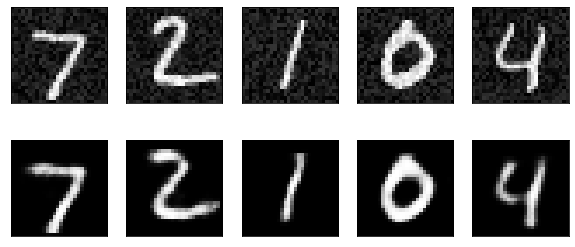

In [ ]:
plot_autoencoder_outputs(model, 5, (28, 28))

## Homework

Do the autoencoders denoising on the MNIST fashion dataset.
Experiment with at least 2 different autoencoders by varying their depth, layer size, etc.

In [6]:
fash_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fash_mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [7]:
fash_mnist_noise = tf.keras.datasets.fashion_mnist
(x_train_noise, y_train_noise), (x_test_noise, y_test_noise) = fash_mnist_noise.load_data()

x_train_noise = x_train_noise + np.random.randint(64, size=(60000, 28, 28))
x_test_noise = x_test_noise + np.random.randint(64, size=(10000, 28, 28))
x_train_noise = x_train_noise.astype('float32') / 255.0
x_test_noise = x_test_noise.astype('float32') / 255.0
x_train_noise = x_train_noise.reshape((len(x_train_noise), np.prod(x_train_noise.shape[1:])))
x_test_noise = x_test_noise.reshape((len(x_test_noise), np.prod(x_test_noise.shape[1:])))

print(x_train_noise.shape)
print(x_test_noise.shape)

(60000, 784)
(10000, 784)


###Model 1

In [8]:
model = tf.keras.Sequential([
          tf.keras.Input(shape=(784,)),
          tf.keras.layers.Dense(128, activation=tf.nn.relu),
          tf.keras.layers.Dense(32, activation=tf.nn.relu), #code layer
          tf.keras.layers.Dense(128, activation=tf.nn.relu),
          tf.keras.layers.Dense(784, activation=tf.nn.sigmoid) #output layer
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                                 
 dense_8 (Dense)             (None, 128)               4224      
                                                                 
 dense_9 (Dense)             (None, 784)               101136    
                                                                 
Total params: 209,968
Trainable params: 209,968
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.fit(x_train_noise, x_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 9s 3ms/step - loss: 0.3173
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2915
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2854
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2825
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2807


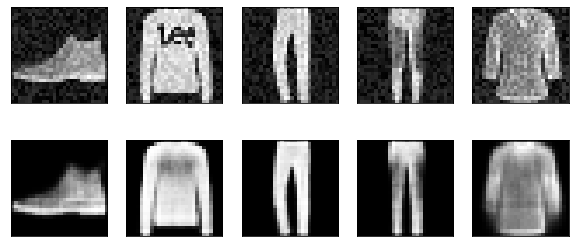

In [10]:
plot_autoencoder_outputs(model, 5, (28, 28))

### Model 2


In [11]:
model = tf.keras.Sequential([
          tf.keras.Input(shape=(784,)),
          tf.keras.layers.Dense(128, activation=tf.nn.relu),
          tf.keras.layers.Dense(128, activation=tf.nn.relu),
          tf.keras.layers.Dense(512, activation=tf.nn.relu),
          tf.keras.layers.Dense(32, activation=tf.nn.relu), #code layer
          tf.keras.layers.Dense(512, activation=tf.nn.relu),
          tf.keras.layers.Dense(128, activation=tf.nn.relu),
          tf.keras.layers.Dense(128, activation=tf.nn.relu),
          tf.keras.layers.Dense(784, activation=tf.nn.sigmoid) #output layer
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               100480    
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dense_12 (Dense)            (None, 512)               66048     
                                                                 
 dense_13 (Dense)            (None, 32)                16416     
                                                                 
 dense_14 (Dense)            (None, 512)               16896     
                                                                 
 dense_15 (Dense)            (None, 128)               65664     
                                                                 
 dense_16 (Dense)            (None, 128)              

In [12]:
model.fit(x_train_noise, x_train, epochs=6)

Epoch 1/6
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3274
Epoch 2/6
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2997
Epoch 3/6
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2922
Epoch 4/6
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2874
Epoch 5/6
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2849
Epoch 6/6
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2831


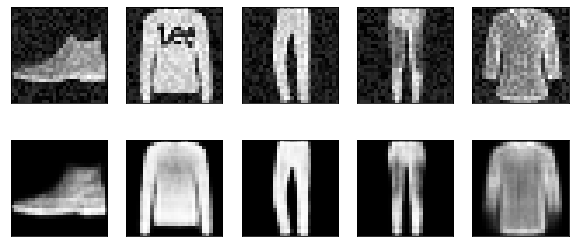

In [13]:
plot_autoencoder_outputs(model, 5, (28, 28))

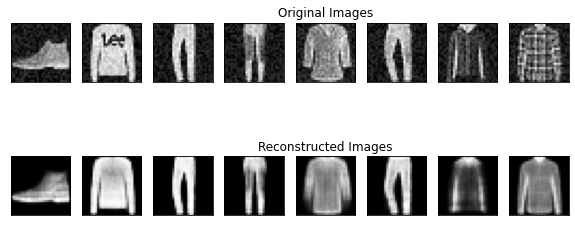

In [17]:
plot_autoencoder_outputs(model, 8, (28, 28))